# SMAC Demo

This notebook demos dataset mixture tuning using SMAC3. We have 8 datasets from which we must select a fixed number of rows $N$, and we optimize the best mixture of datasets to select from.

Some details
  - The datasets have two dependent variables (`X` and `Y`) and one independent variable (`Z`)
  - There are 8 datasets - A-D are the "good" ones, E-H are "bad" ones. Dataset I is a validation set. See `data_generation.py` for details on how they are generated.
  - For simplicity, the model we're training to predict `Z` based on `X` and `Y` is a random forest with a maximum tree depth of 6. 

Two key aspects of the optimization
  1. It uses Bayesian Optimization with an EI acquisition function, and a (different) random forest as a backing model
  2. It uses multi-fidelity optimization to eliminate parameter combinations as they are being trained. In particular, the "number of steps" in training each random forest to predict `Z` from `X` and `Y` will be the number of trees in the RF.

To parameterize the mixture, we use eight parameters $w_A$ through $w_H$ - each between 0 and 100. We will normalize these to sum to 1 to determine the proportion of each dataset we'll select - i.e., the proportion of dataset $i$ in our training sample will be $w_i / \sum_j w_j$.

**Note**: SMAC seems to be incompatible with the latest version of numpy. Use numpy 1.26.4 instead.

In [18]:
import data_generation

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn.ensemble as sk_e
import sklearn.metrics as sk_m

import smac
import ConfigSpace

import pickle

### Generate synthetic data

In [19]:
data = data_generation.generate_data()

In [20]:
data.keys()

dict_keys(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I'])

In [21]:
data['A'].head()

,X,Y,Z
0,-5.000000,0.0,438.058005
1,-4.924623,0.0,149.460274
2,-4.849246,0.0,401.783565
3,-4.773869,0.0,429.832159
4,-4.698492,0.0,282.095170


### Prepare training function

In [22]:
# Create a dictionary to store models in memory as they are trained; see
# doctstring for train() for an explanation. IRL, we'd need to save this
# to disk presumably
trained_models = {}

In [23]:
def train(config, seed, budget):
    '''
    This function takes a parameter combination from the SMAC3 optimizer, trains a
    model with it, and returns the model's performance from the validation set I.

    It accepts the following arguments:
      - config : a configuration object containing wA-wH, each numbers in [0, 100].
                 We normalize the numbers to sum to 1 to figure out the weight of
                 each dataset in our training sample
      - seed : the random seed to use
      - budget : the number of trees to use in the random forest. If this configuration
                 has been trained before with a lower budget, we retrieve that lower-
                 budget trained model from the trained_models dictionary and pick up
                 from where we left off to save time.
    '''

    # Normalize the wA-wH variables in our configuration
    # --------------------------------------------------
    weights = {i : config.get(f'w{i}') for i in ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']}
    weights = {i : weights[i] / sum(weights.values()) for i in weights}

    # Check whether we already have a trained model
    # ---------------------------------------------
    serialized_config = str(sorted([f'{k}:{round(v, 5)}' for k, v in weights.items()]))
    global trained_models

    # Retrieve our previous trained model or create a new one and put it in the dict;
    # warm_start = True is needed to make sure we can pick up from where we left off next time
    # we use this model
    trained_models[serialized_config] = trained_models.get(serialized_config,
                                                           sk_e.RandomForestRegressor(n_estimators=0, random_state=seed, max_depth=6, warm_start=True))
    m = trained_models[serialized_config]
    
    # If the model has been trained before, we should only be seeing it again with a
    # higher budget (if the model was just created it'll have been created with a budget
    # of 0, so this will be true)
    assert int(budget) >= m.n_estimators
    
    # Set the budget
    m.n_estimators = int(budget)
    
    # Get the data we're training on
    # ------------------------------
    this_data = []
    for ds in weights:
        this_data.append(data[ds].sample(int(len(data[ds])*weights[ds]), random_state=seed))
    this_data = pd.concat(this_data)

    # Train
    # -----
    m.fit(X=this_data[['X', 'Y']], y=this_data['Z'])
    
    # Return the performance on the eval set (I)
    # ------------------------------------------
    return(sk_m.mean_squared_error(data['I']['Z'], m.predict(data['I'][['X', 'Y']])))

In [24]:
# Store the best and worse MSEs
best_mse  = train({'wA':1, 'wB':1, 'wC':1, 'wD':1, 'wE':0, 'wF':0, 'wG':0, 'wH':0}, seed=123, budget=30)
worst_mse = train({'wA':0, 'wB':0, 'wC':0, 'wD':0, 'wE':1, 'wF':1, 'wG':1, 'wH':1}, seed=123, budget=30)

# Clear the saved models
trained_models = {}

### SMAC

Create a configuration space, describing all the values, and the values they can take

In [25]:
cs = ConfigSpace.ConfigurationSpace()

for ds in ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']:
    cs.add_hyperparameter(ConfigSpace.Float(f'w{ds}', [0, 100]))
    
cs

Configuration space object:
  Hyperparameters:
    wA, Type: UniformFloat, Range: [0.0, 100.0], Default: 50.0
    wB, Type: UniformFloat, Range: [0.0, 100.0], Default: 50.0
    wC, Type: UniformFloat, Range: [0.0, 100.0], Default: 50.0
    wD, Type: UniformFloat, Range: [0.0, 100.0], Default: 50.0
    wE, Type: UniformFloat, Range: [0.0, 100.0], Default: 50.0
    wF, Type: UniformFloat, Range: [0.0, 100.0], Default: 50.0
    wG, Type: UniformFloat, Range: [0.0, 100.0], Default: 50.0
    wH, Type: UniformFloat, Range: [0.0, 100.0], Default: 50.0

Create a scenario

In [26]:
scenario = smac.Scenario(cs,
                         walltime_limit = 30,
                         n_trials = 5000,
                         min_budget=1,
                         max_budget=30,
                         n_workers=1)

Use a hyperband intensifier. Train the random forests only on the highest budget runs

In [27]:
intensifier = smac.intensifier.hyperband.Hyperband(scenario, incumbent_selection='highest_budget', seed=123)

Create the optimizer

In [28]:
smac_instance = smac.MultiFidelityFacade(scenario,
                                         train,
                                         initial_design=smac.MultiFidelityFacade.get_initial_design(scenario),
                                         intensifier=intensifier,
                                         overwrite=True)

[INFO][abstract_initial_design.py:147] Using 80 initial design configurations and 0 additional configurations.


Optimize

In [29]:
out_params = smac_instance.optimize()

[INFO][successive_halving.py:164] Successive Halving uses budget type BUDGETS with eta 3, min budget 1, and max budget 30.
[INFO][successive_halving.py:323] Number of configs in stage:
[INFO][successive_halving.py:325] --- Bracket 0: [27, 9, 3, 1]
[INFO][successive_halving.py:325] --- Bracket 1: [12, 4, 1]
[INFO][successive_halving.py:325] --- Bracket 2: [6, 2]
[INFO][successive_halving.py:325] --- Bracket 3: [4]
[INFO][successive_halving.py:327] Budgets in stage:
[INFO][successive_halving.py:329] --- Bracket 0: [1.1111111111111112, 3.333333333333333, 10.0, 30.0]
[INFO][successive_halving.py:329] --- Bracket 1: [3.333333333333333, 10.0, 30.0]
[INFO][successive_halving.py:329] --- Bracket 2: [10.0, 30.0]
[INFO][successive_halving.py:329] --- Bracket 3: [30.0]
[INFO][abstract_intensifier.py:515] Added config e78670 as new incumbent because there are no incumbents yet.
[INFO][smbo.py:319] Finished 50 trials.
[INFO][abstract_intensifier.py:594] Added config 304420 and rejected config e7867

### See how we did

In [30]:
print(smac_instance.validate(cs.get_default_configuration()))
cs.get_default_configuration()

429575.7659162852


Configuration(values={
  'wA': 50.0,
  'wB': 50.0,
  'wC': 50.0,
  'wD': 50.0,
  'wE': 50.0,
  'wF': 50.0,
  'wG': 50.0,
  'wH': 50.0,
})

In [31]:
print(smac_instance.validate(out_params))
out_params

15683.406740249264


/opt/homebrew/anaconda3/envs/recipes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:468: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  warn(


Configuration(values={
  'wA': 96.6382907159513,
  'wB': 62.40138738978358,
  'wC': 94.78797748168273,
  'wD': 89.82495835922916,
  'wE': 0.0014105757958104634,
  'wF': 2.084866874339048,
  'wG': 0.0477392039980859,
  'wH': 0.01232748390749787,
})

## Visualizations

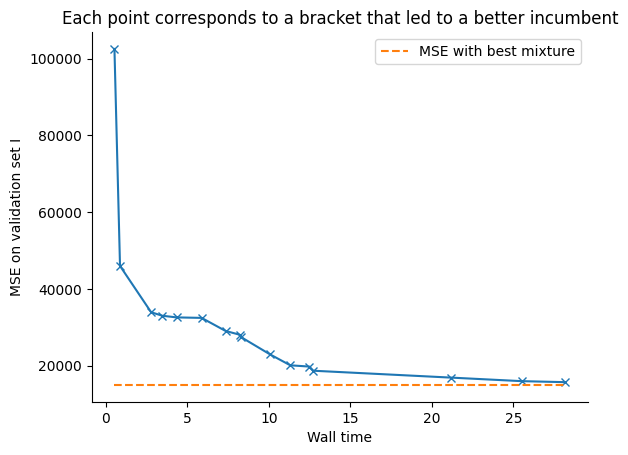

In [32]:
x = []
y = []
for t in smac_instance.intensifier.trajectory:
    x.append(t.walltime)
    y.append(t.costs[0])

plt.plot(x, y, 'x-')

baseline, = plt.plot([min(x), max(x)], [best_mse, best_mse], linestyle='--')

plt.legend([baseline], ['MSE with best mixture'])

plt.xlabel('Wall time')
plt.ylabel('MSE on validation set I')
plt.title('Each point corresponds to a bracket that led to a better incumbent')

sns.despine()

Display each bracket

SHOWING RUN 1


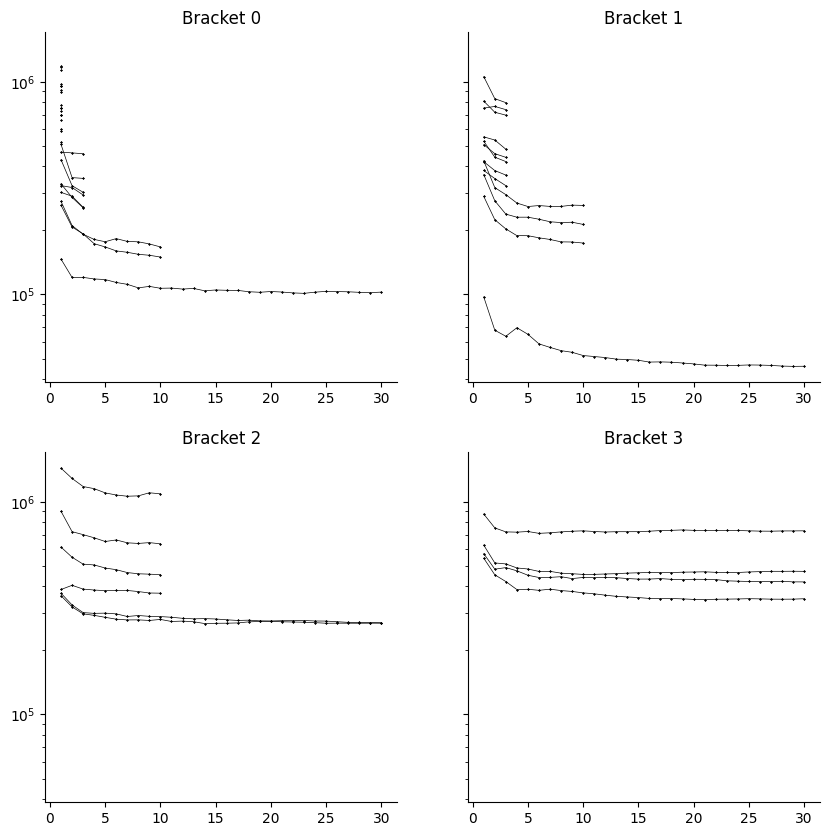

SHOWING RUN 2


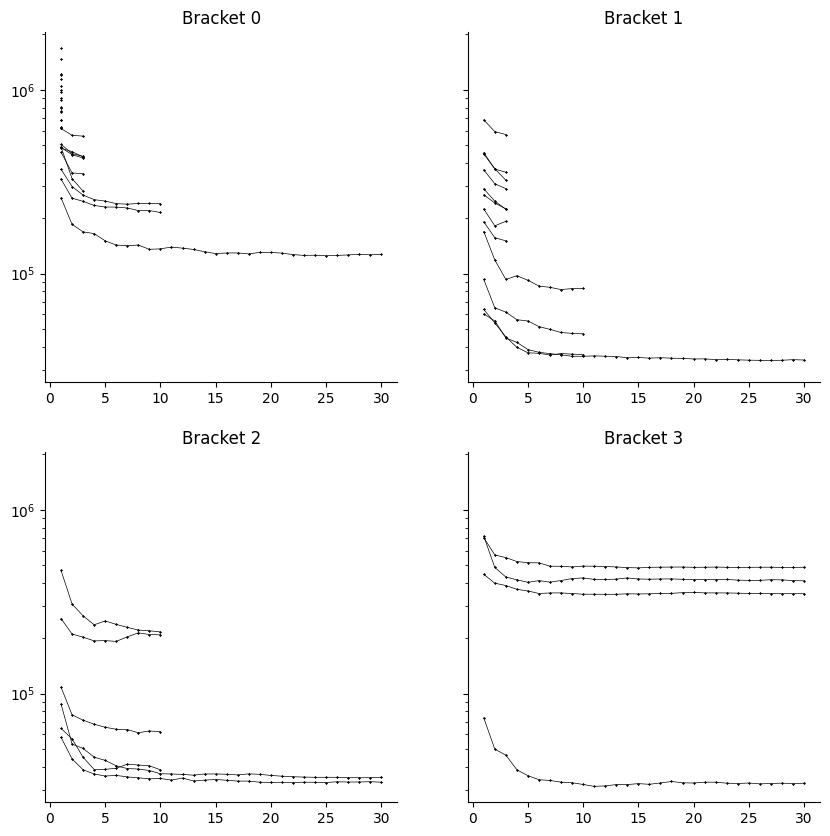

SHOWING RUN 3


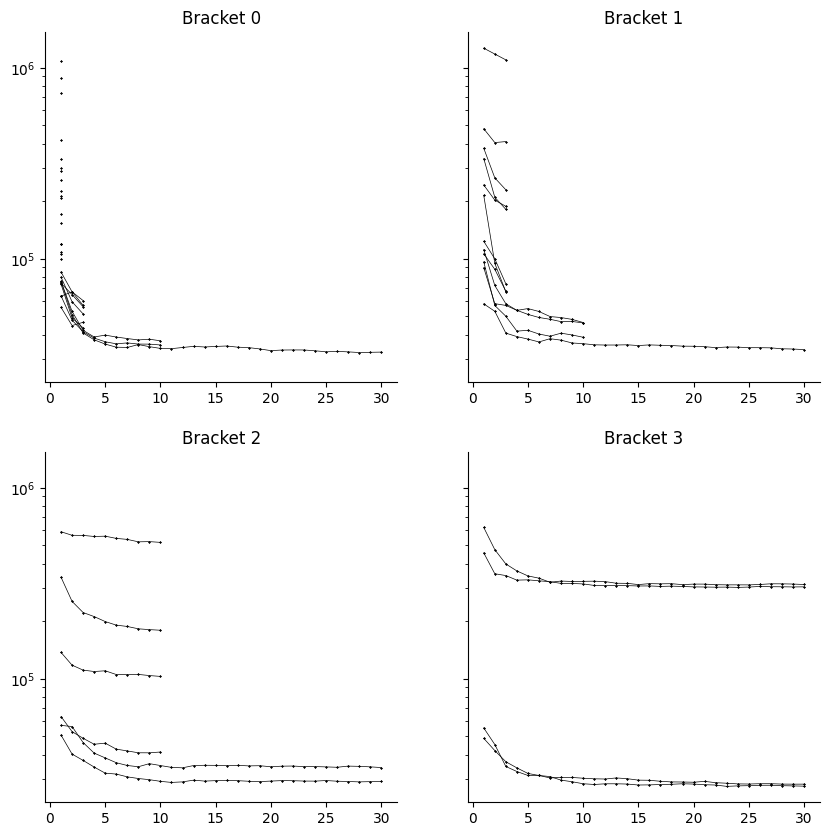

SHOWING RUN 4


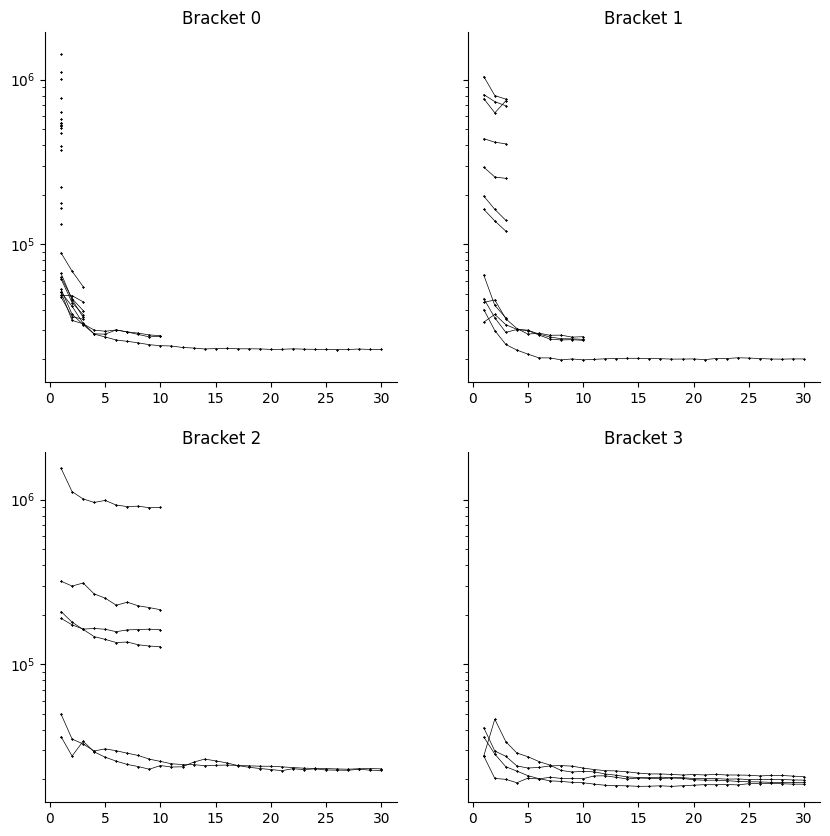

SHOWING RUN 5


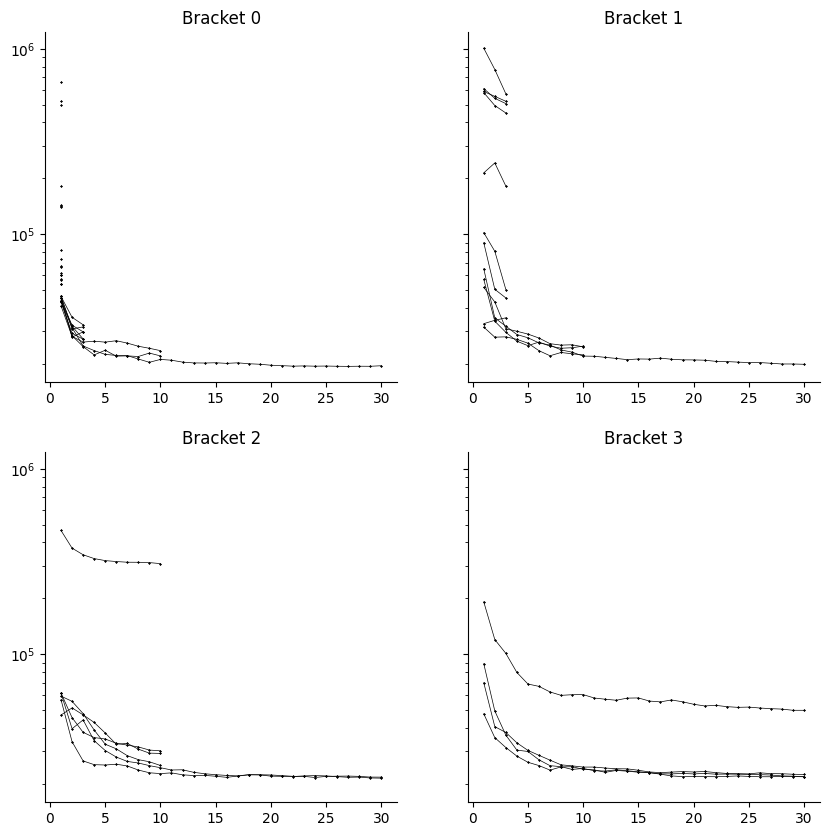

SHOWING RUN 6


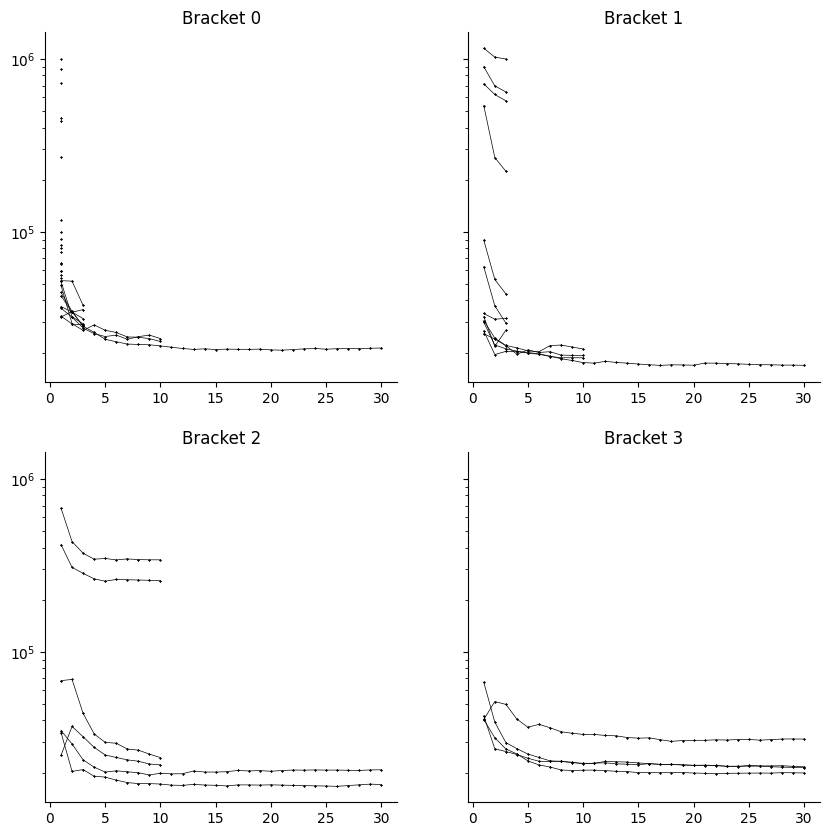

SHOWING RUN 7


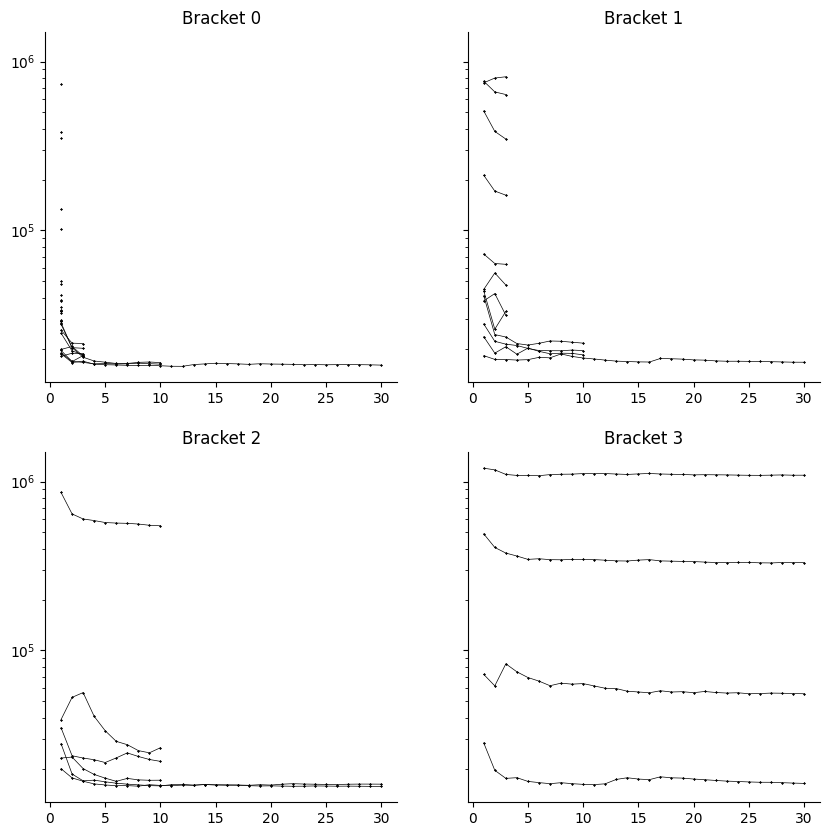

SHOWING RUN 8


In [33]:
def show_run(run_id):
    print(f'SHOWING RUN {run_id}')

    # Get the bracket configurations, and the total number of configurations
    # in each run
    bracket_sizes = intensifier._n_configs_in_stage
    configs_per_run = sum([sum(v) for k, v in bracket_sizes.items()])

    # Get all the configurations for this run
    if len(list(smac_instance.runhistory)) < configs_per_run*run_id:
        return False
    
    run_history = [smac_instance.runhistory.get_config(t.config_id)
                        for t in list(smac_instance.runhistory)[configs_per_run*(run_id-1):][:configs_per_run]]

    # Create  axes
    rows = int(np.ceil(len(bracket_sizes)/2))
    fig, ax = plt.subplots(rows, 2, figsize=(5*rows, 10), sharey=True)

    # For each bracket, the first configurations are the unique ones (the rest are
    # just extending the budget). Find those configurations for each budget
    bracket_configs = {}
    cur_config = 0
    for bracket_n in range(len(bracket_sizes)):
        bracket_configs[bracket_n] = run_history[cur_config:(cur_config+bracket_sizes[bracket_n][0])]
        cur_config += sum(bracket_sizes[bracket_n])

    # Plot the brackets
    for bracket, axis in zip(bracket_configs, ax.flatten()):
        for config in bracket_configs[bracket]:
            weights = {i : config.get(f'w{i}') for i in ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']}
            weights = {i : weights[i] / sum(weights.values()) for i in weights}
            m = trained_models[str(sorted([f'{k}:{round(v, 5)}' for k, v in weights.items()]))]

            preds = np.vstack([e.predict(data['I'][['X', 'Y']].values) for e in m.estimators_])
            preds = np.cumsum(preds, axis=0) / np.arange(1, preds.shape[0] + 1)[:, None]
            errs = [sk_m.mean_squared_error(data['I']['Z'], p) for p in preds]

            axis.plot([i + 1 for i in range(len(errs))], errs, marker='x', markersize=1, linestyle='-', linewidth=0.5, color='black')
        
        axis.set_title(f'Bracket {bracket}')

        axis.semilogy()
        sns.despine()
    
    plt.show()

    return True

run_id = 1
while show_run(run_id):
    run_id += 1